In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import random
import gc
import datetime

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
path_data = "../input/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

In [2]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
df_train = pd.read_csv(path_train)
df_train = reduce_mem_usage(df_train, use_float16=False)
df_train.head()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
building = pd.read_csv(path_building)
building = reduce_mem_usage(building, use_float16=False)
building.head()

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 65.4%


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)
weather_train = pd.read_csv(path_weather_train)
weather_train = reduce_mem_usage(weather_train, use_float16=False)
weather_train.head()

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 4.51 MB
Decreased by 53.0%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [6]:
def extract_id_meter(df, building_id, meter):
    temp = df[df['building_id'] == building_id].copy()
    temp = temp[temp['meter'] == meter]
    return temp

In [7]:
def prep_core_data(df):
    # Interpolate    ####################################################################
    for _id in range(df['building_id'].nunique()):
        for meter in df['meter'].unique().tolist():
            # Extract by building_id, meter
            temp = extract_id_meter(df, _id, meter)
            temp = temp.sort_values(by='timestamp')

            if temp.empty:
                continue

            # Deal the values between 0 and 0 as Nan
            temp['shifted_past'] = temp['meter_reading'].shift()
            temp['shifted_future'] = temp['meter_reading'].shift(-1)
            drop_rows = temp.query("shifted_past == 0 & shifted_future == 0 & meter_reading > 0")
            df.loc[drop_rows.index, 'meter_reading'] = 0

            # Smoothing
            upper = np.percentile(temp['meter_reading'], 99)
            lower = np.percentile(temp['meter_reading'], 1)
            temp.loc[temp['meter_reading'] > upper, 'meter_reading'] = np.nan
            temp.loc[temp['meter_reading'] < lower, 'meter_reading'] = np.nan

            # Use Interpolation for Filling NaN
            temp['meter_reading'] = temp['meter_reading'].interpolate(limit_area='inside', limit=1)
            # Adapt to orginal data
            df.loc[temp.index, 'meter_reading'] = temp.loc[temp.index, 'meter_reading']

            del temp
            gc.collect()

    # Dropna  ####################################################################
    df.dropna(subset=['meter_reading'], inplace=True)

    return df

In [8]:
%%time
df_train = prep_core_data(df_train)

Wall time: 15min 21s


In [9]:
def prep_weather_data(df, mode='train'):

    # Convert GMT  #####################################################################
    # reference  https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
#     GMT_converter = {0: 4, 1: 0, 2: 7, 3: 4, 4: 7, 5: 0, 6: 4, 7: 4, 8: 4, 9: 5, 10: 7, 11: 4, 12: 0, 13: 5, 14: 4, 15: 4}

#     for i in range(16):
#         temp = df[df['site_id'] == i].copy()
#         temp['timestamp'] = pd.to_datetime(temp['timestamp'].values)
#         temp.sort_values(by='timestamp', inplace=True)
#         temp['timestamp'] = temp['timestamp'] - datetime.timedelta(hours=GMT_converter[i])
#         temp['timestamp'] = temp['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %T'))
#         df.loc[temp.index, 'timestamp'] = temp.loc[temp.index, 'timestamp']
#         del temp
#         gc.collect()

    # Create Features per Site Id  #####################################################################
    # Fillna(Interpolate)
#     for i in range(df['site_id'].nunique()):
#         temp = df[df['site_id'] == i].copy()
#         temp = temp.sort_values(by='timestamp')

#         # Interpolation
#         # mixed Linear & Cubic Method  https://www.kaggle.com/c/ashrae-energy-prediction/discussion/116012#latest-667255
#         cols = ['air_temperature', 'dew_temperature', 'wind_direction', 'wind_speed']
#         for c in cols:
#             temp[c] = temp[c].interpolate(method='linear', limit_direction='both')
#             df.loc[temp.index, c] = temp.loc[temp.index, c]

#         del temp
#         gc.collect()

    # relative Hummd  #####################################################################
    # https://soudan1.biglobe.ne.jp/qa5356721.html
    a_temp = df['air_temperature'].values
    d_temp = df['dew_temperature'].values

    def SaturatedWaterVaporPressure(values):
        return 6.11 * 10 ** (7.5 * values / (237.3 + values))

    a_temp = SaturatedWaterVaporPressure(a_temp)
    d_temp = SaturatedWaterVaporPressure(d_temp)

    df['relative_hummd'] = d_temp / a_temp * 100
    del a_temp, d_temp
    gc.collect()

    # Disconfort Index  #####################################################################
    # https://keisan.casio.jp/exec/system/1202883065

    def disconfort_index(row):
        T = row['air_temperature']
        RH = row['relative_hummd']
        return 0.81 * T + 0.01 * RH * (0.99 * T - 14.3) + 46.3

    df['DI'] = df.apply(disconfort_index, axis=1)

    # Apparent Temperature  #####################################################################
    # https://keisan.casio.jp/exec/system/1257417058

    def apparent_temperature(row):
        T = row['air_temperature']
        RH = row['relative_hummd']
        A = 1.76 + 1.4 * row['wind_speed'] ** 0.75
        return 37 - (37 - T) / (0.68 - 0.0014 * RH + 1/A) - 0.29 * T * (1 - RH / 100)

    df['AT'] = df.apply(apparent_temperature, axis=1)

    # WCI  #####################################################################
    # https://www.metsoc.jp/tenki/pdf/2010/2010_01_0057.pdf

    def WCI(row):
        T = row['air_temperature']
        U = row['wind_speed']
        return (33 - T) * (10.45 + 10 * U ** 0.5 - U)

    df['WCI'] = df.apply(WCI, axis=1)

    # Wind Direction  #####################################################################
    df.loc[df['wind_direction'] == 65535, 'wind_direction'] = np.nan
    df.loc[df['wind_direction'] == 360, 'wind_direction'] = 0
    df['wind_direction'] = np.radians(df['wind_direction'])
    df['wind_direction_sin'] = np.sin(df['wind_direction'])
    df['wind_direction_cos'] = np.cos(df['wind_direction'])

    df['wind_speed_sin'] = df['wind_speed'] * df['wind_direction_sin']
    df['wind_speed_cos'] = df['wind_speed'] * df['wind_direction_cos']

    for c in ['wind_speed_sin', 'wind_speed_cos']:
        df[c] = df[c].astype(np.float16)

    # beaufort_scale  #####################################################################
    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9),
                (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

    for item in beaufort:
        df.loc[(df['wind_speed'] >= item[1]) & (df['wind_speed'] < item[2]), 'beaufort_scale'] = item[0]

    # Create Features per Site Id  #####################################################################
    for i in range(df['site_id'].nunique()):
        temp = df[df['site_id'] == i]
        temp = temp.sort_values(by='timestamp')
        # Rolling
        cols = ['relative_hummd', 'DI', 'AT']
        for c in cols:
            for window in [24, 48, 72]:
                # Mean
                colname = '{}_roll_{}_mean'.format(c, window)
                temp[colname] = temp[c].rolling(window).mean()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float32)
                # Max
                colname = '{}_roll_{}_max'.format(c, window)
                temp[colname] = temp[c].rolling(window).max()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float32)
                # Min
                colname = '{}_roll_{}_min'.format(c, window)
                temp[colname] = temp[c].rolling(window).min()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float32)

        # Shift
        cols = ['relative_hummd', 'DI', 'AT']
        for c in cols:
            for period in [24, 48, 72]:
                colname = '{}_shift_{}'.format(c, period)
                shifted = temp[c].shift(periods=period)
                temp[colname] = temp[c] - shifted
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float32)

        del temp
        gc.collect()

    return df


In [10]:
%%time
weather_train = prep_weather_data(weather_train)

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

In [11]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    gc.collect()
    
    # Data Cleaning
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)
    
    # Category
    categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]
    for c in categorical_features:
        X[c] = X[c].astype('category')
    

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [12]:
X_train, y_train = prepare_data(df_train, building, weather_train)
del df_train, weather_train
gc.collect()

57

In [13]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_train[:int(X_train.shape[0] / 2)], label=y_train[:int(X_train.shape[0] / 2)])
d_half_2 = lgb.Dataset(X_train[int(X_train.shape[0] / 2):], label=y_train[int(X_train.shape[0] / 2):])

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=5000, valid_sets=[d_half_1, d_half_2], verbose_eval=500, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=5000, valid_sets=[d_half_2, d_half_1], verbose_eval=500, early_stopping_rounds=200)

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 0.841948	valid_1's rmse: 1.33043
Early stopping, best iteration is:
[403]	training's rmse: 0.857616	valid_1's rmse: 1.32965
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 0.837625	valid_1's rmse: 1.49707
Early stopping, best iteration is:
[562]	training's rmse: 0.828294	valid_1's rmse: 1.49656


** Feature Importance **

Plotting the feature importance from LGBM.

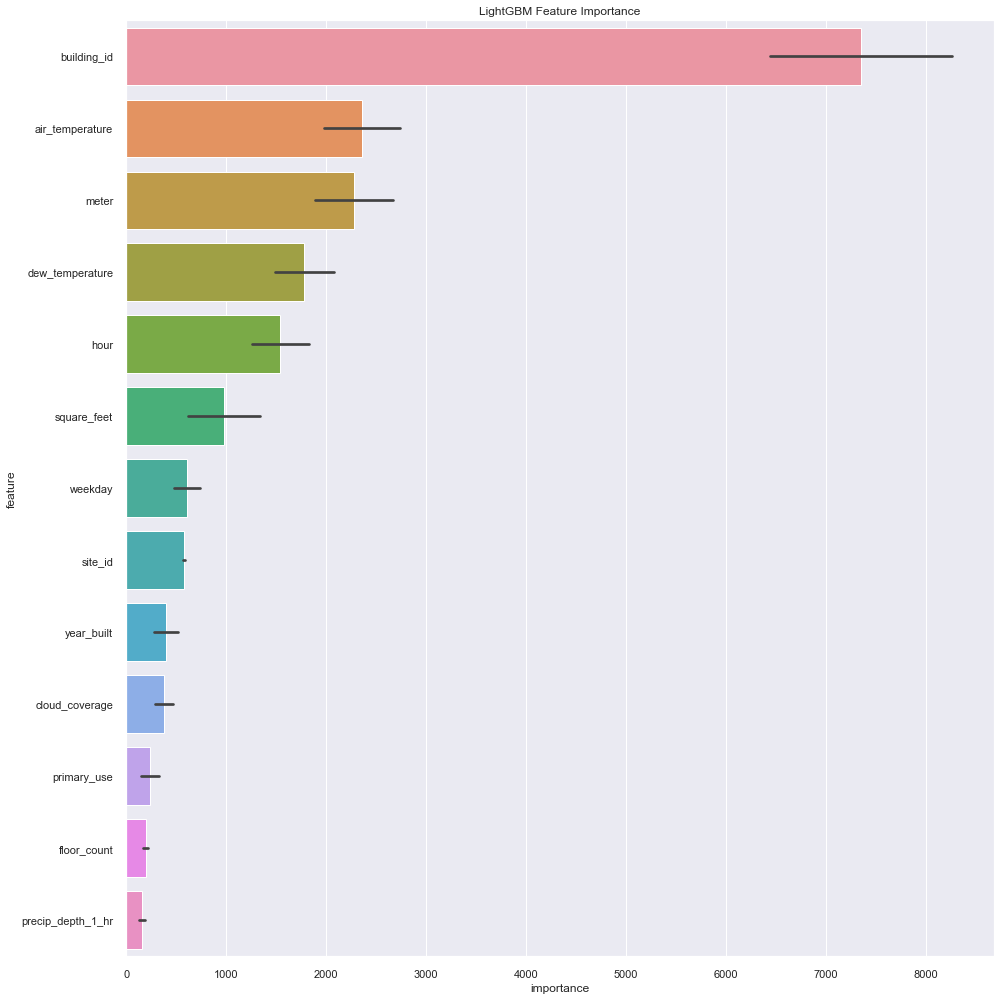

In [14]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 14))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [15]:
del df_fimp_1, df_fimp_2, X_train, y_train, df_fimp
gc.collect()

4492

Preparing test data 

Preparing test data with same features as train data.

In [16]:
%%time
df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test)

df_test = reduce_mem_usage(df_test)
weather_test = prep_weather_data(weather_test)
weather_test = reduce_mem_usage(weather_test)

gc.collect()

# Divide Half Test Data (for memory)
X_test_1, row_ids_1 = prepare_data(df_test[:int(df_test.shape[0] / 2)], building, weather_test, test=True)
X_test_1 = reduce_mem_usage(X_test_1)

print('Pred_1')
pred_1 = np.expm1(model_half_1.predict(X_test_1, num_iteration=model_half_1.best_iteration)) / 2
pred_1 += np.expm1(model_half_2.predict(X_test_1, num_iteration=model_half_2.best_iteration)) / 2

del X_test_1
gc.collect()

X_test_2, row_ids_2 = prepare_data(df_test[int(df_test.shape[0] / 2):], building, weather_test, test=True)
X_test_2 = reduce_mem_usage(X_test_2)

print('Pred_2')
pred_2 = np.expm1(model_half_1.predict(X_test_2, num_iteration=model_half_1.best_iteration)) / 2
pred_2 += np.expm1(model_half_2.predict(X_test_2, num_iteration=model_half_2.best_iteration)) / 2

del X_test_2, weather_test, df_test
gc.collect()

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 72.97 MB
Memory usage after optimization is: 56.55 MB
Decreased by 22.5%
Memory usage of dataframe is 4513.48 MB
Memory usage after optimization is: 4433.95 MB
Decreased by 1.8%
Pred_1


LightGBMError: The number of features in data (58) is not the same as it was in training data (13).

In [17]:
pred = np.concatenate([pred_1, pred_2])
row_ids = np.concatenate([row_ids_1, row_ids_2])
del pred_1, pred_2, row_ids_1, row_ids_2
gc.collect()

NameError: name 'pred_1' is not defined

In [ ]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("/Output/submission.csv", index=False)
print("DONE")

In [ ]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))